In [1]:
# General Dependencies
import os
import numpy as np

# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate

# PMD Model Dependencies
from trefide.pmd import blockwise_decompose, format_as_matrices

# Plotting & Video Rendering Dependencies
import matplotlib.pyplot as plt
from trefide.plot import pixelwise_ranks
from trefide.video import play_cv2

# Set Demo Dataset Location
ext = os.path.join("..", "..", "data")
filename = os.path.join(ext, "demoMovie.npy")

%load_ext autoreload
%autoreload 2

# Load Preprocessed Data

In [2]:
mov = np.load(filename)
fov_height, fov_width, num_frames = mov.shape

# Set Params

In [3]:
# Generous maximum of rank 50 blocks (safeguard to terminate early if this is hit)
max_components = 50

# Enable Decimation 
max_iters_main = 10
max_iters_init = 40
d_sub=2
t_sub=2

# Defaults
consec_failures = 3
tol = 5e-3

# Set Blocksize Parameters
block_height = 40
block_width = 40
overlapping = True

# Compress Video

## Simulate Critical Region Using Noise

In [4]:
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames),
                                                       (block_height, block_width),
                                                       consec_failures, max_iters_main, 
                                                       max_iters_init, tol, 
                                                       d_sub, t_sub, 5, True)

NameError: name 'determine_thresholds' is not defined

In [5]:
spatial_thresh, temporal_thresh = (1.11, 1.74)

## Decompose Each Block Into Spatial & Temporal Components

In [6]:
spatial_components,\
temporal_components,\
metadata = blockwise_decompose(mov, fov_height, fov_width, num_frames,
                               block_height, block_width,
                               spatial_thresh, temporal_thresh,
                               max_components, consec_failures,
                               max_iters_main, max_iters_init, tol,
                               overlapping=overlapping, d_sub=d_sub, t_sub=t_sub)

In [6]:
U, V = format_as_matrices(spatial_components, temporal_components, metadata)

In [7]:
mov_denoised = np.reshape(U.dot(V), (fov_height, fov_width, num_frames), order='F')

In [9]:
from timeit import timeit as timeit

In [10]:
def reconstruct():
    return U.dot(V)

timeit(reconstruct, number=10)

25.97212006058544

In [9]:
if overlapping:
    mov_denoised /= 4

In [10]:
np.prod(mov.shape) / (len(U.data) + np.prod(V.shape))

73.68800686835546

In [8]:
def gram_mat():
    return V.T.dot(U.T.dot(U).dot(V))

timeit(gram_mat, number=10)

2.754319290001149

In [9]:
Y = mov.reshape((fov_height * fov_width, num_frames))
def gram_mat():
    return V.T.dot(U.T.dot(Y))

timeit(gram_mat, number=10)

17.633615752001788

In [10]:
Y = mov.reshape((fov_height * fov_width, num_frames))
def gram_mat():
    return Y.T.dot(Y)

timeit(gram_mat, number=10)

106.37228213699927

In [12]:
def gram_mat():
    return U.dot(V.dot(U.dot(V).T))
timeit(gram_mat, number=10)

608.1700002399994

In [ ]:
Y = mov.reshape((fov_height * fov_width, num_frames))
def gram_mat():
    return U.dot(V).dot(Y.T)

timeit(gram_mat, number=10)

Local correlation:  range [-2.8e-02 5.2e-01]
Local correlation:  range [-8.1e-01 1.0e+00]
Local correlation:  range [-5.6e-02 6.3e-02]


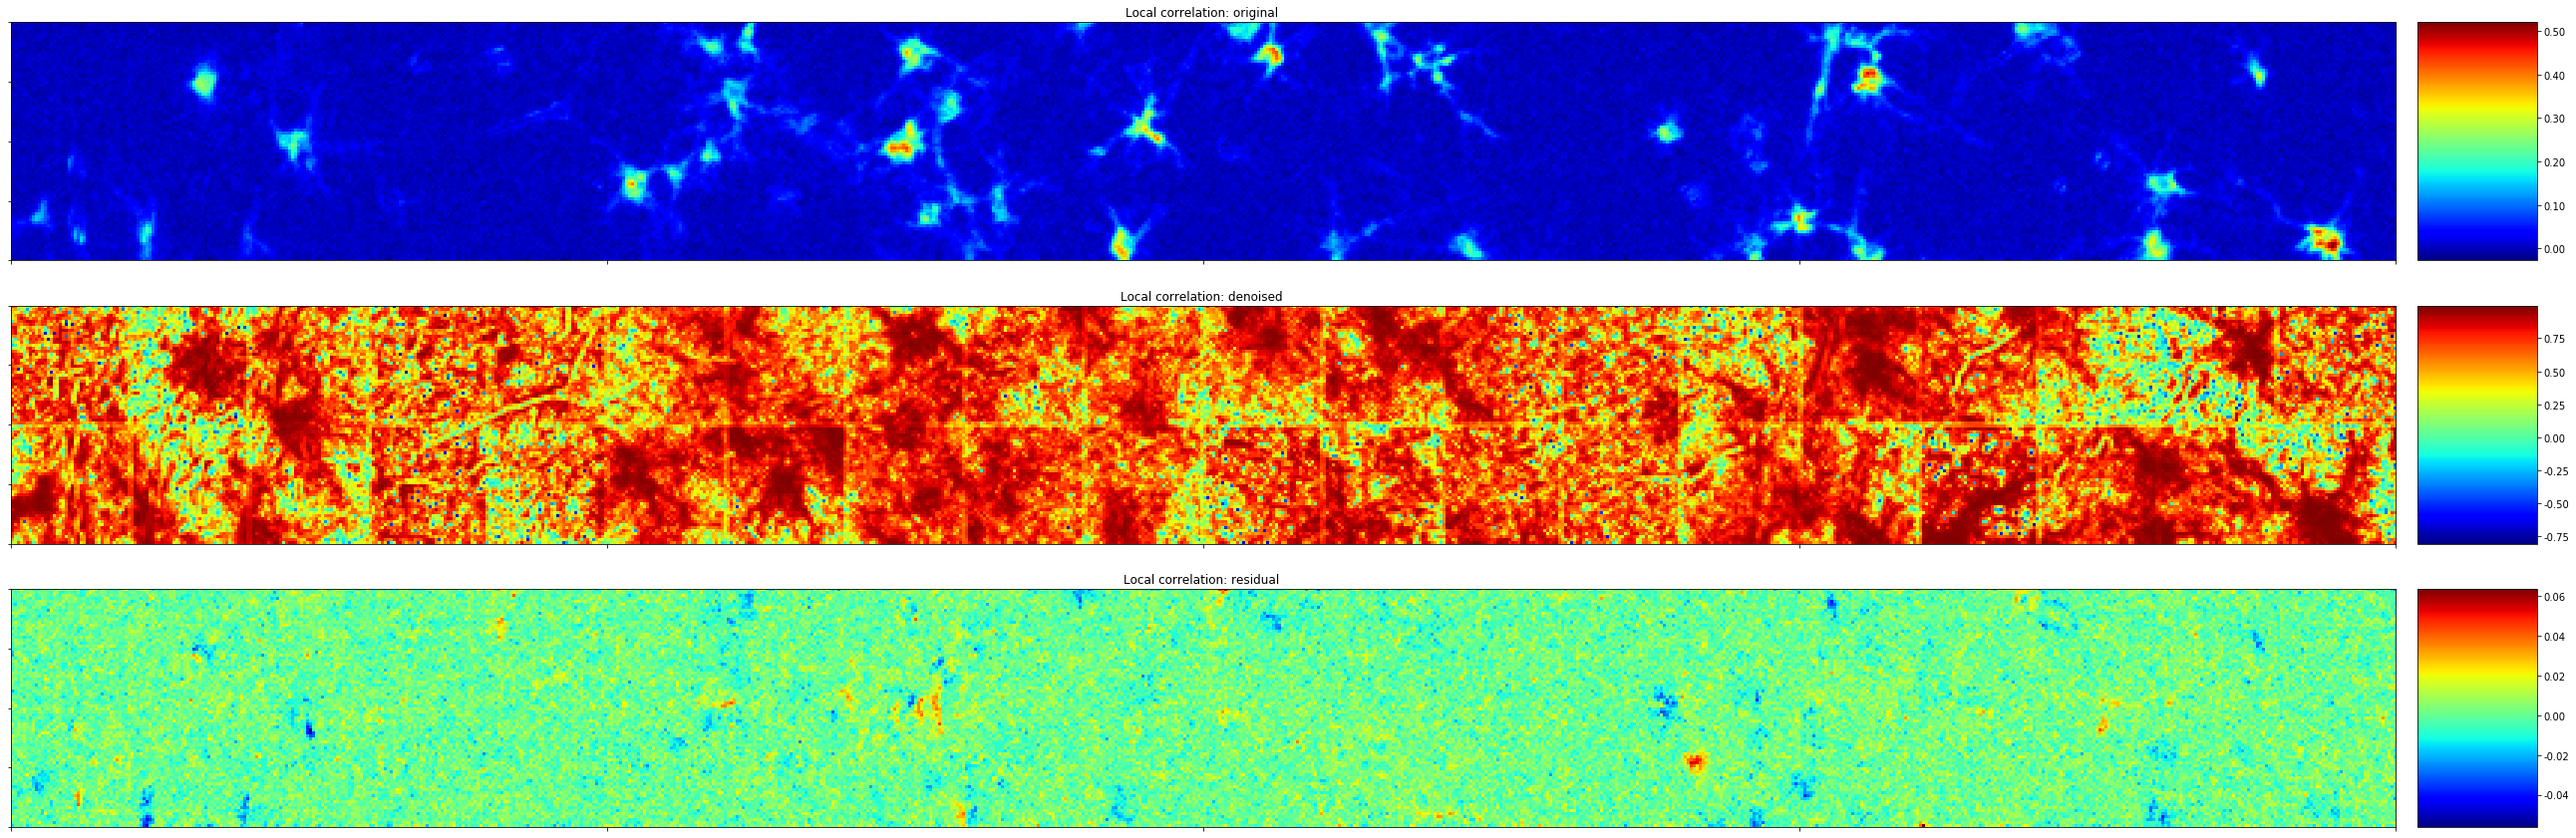

In [8]:
comparison_plot([mov, mov_denoised + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01],
                plot_orientation="horizontal")

In [9]:
play_cv2(np.vstack([mov, mov_denoised, mov-mov_denoised]), magnification=2)

# Produce Diagnostics

### Single Tiling Pixel-Wise Ranks

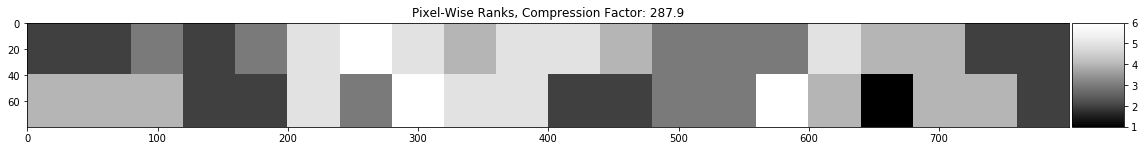

In [ ]:
if overlapping:
    pixelwise_ranks(block_ranks['no_skew']['full'], fov_height, fov_width, num_frames, block_height, block_width)
else:
    pixelwise_ranks(block_ranks, fov_height, fov_width, num_frames, block_height, block_width)

### Correlation Images

In [ ]:
comparison_plot([mov, mov_denoised + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01],
                plot_orientation="horizontal")

Local correlation:  range [-2.8e-02 5.2e-01]


## Render Videos & Residual

In [ ]:
play_cv2(np.vstack([mov, mov_denoised, mov-mov_denoised]), magnification=2)

# Save Results

In [ ]:
U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
                                      block_height, block_width,
                                      spatial_components,
                                      temporal_components,
                                      block_ranks,
                                      block_indices,
                                      block_weights)

In [ ]:
np.savez(os.path.join(ext, "demo_results.npz"), U, V)